# Data Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')
with open('170101_190131過去電力供需資訊.csv', 'r') as f:
    data = pd.read_csv(f, parse_dates=['日期'], date_parser=dateparse, index_col=0)
data['Weekday'] = data.index.weekday
y_data = pd.Series(data['尖峰負載(MW)'],index=data.index)

plt.figure(figsize = (20,5))
plt.plot(y_data['2017'])
plt.title('2017 Peaking Power')
plt.figure(figsize = (20,5))
plt.plot(y_data['2018'])
plt.title('2018 Peaking Power')

Text(0.5, 1.0, '2018 Peaking Power')

  * 先觀察電力尖峰負載根據時間變化的趨勢，發現在夏季明顯升高

## 電力尖峰負載與氣溫

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d')
with open('Taipei_temperature.csv', 'r') as f:   
     weather = pd.read_csv(f, parse_dates=['date'], date_parser=dateparse, index_col=0)
temper = pd.Series(weather['Temperature'],index=weather.index)
max_temper = pd.Series(weather['T Max'],index=weather.index)

  * 讀入每日平均溫度、最高溫度的資料
  * 選用台北測站的資料，因為台北是民生用電佔比最多的地區

Text(0.5, 1.0, '2018 Peaking Power and Temperature')

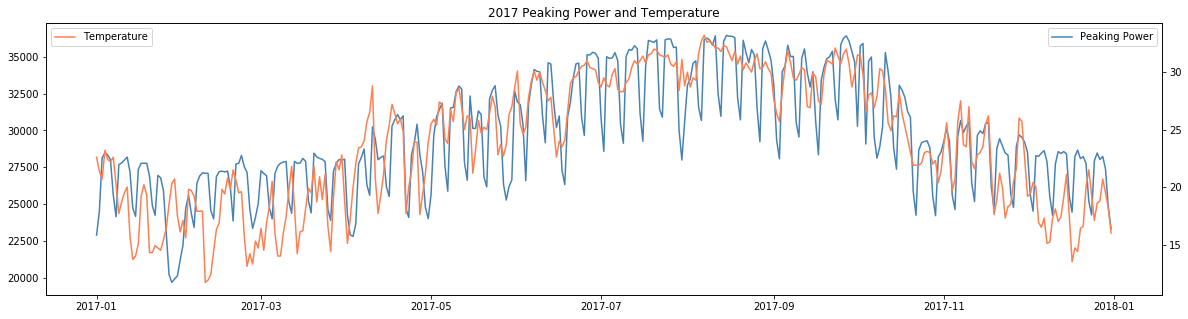

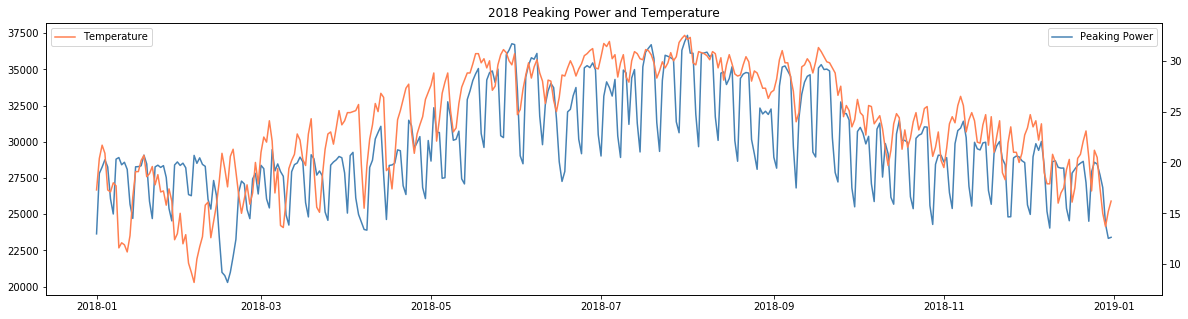

In [4]:
fig17 = plt.figure(figsize = (20,5))
ax1 = fig17.add_subplot(111)
ax1.plot(y_data['2017'],color='steelblue',label='Peaking Power')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()
ax2.plot(temper['2017'],color='coral',label='Temperature')
ax2.legend(loc='upper left')
plt.title('2017 Peaking Power and Temperature')

fig18 = plt.figure(figsize = (20,5))
ax1 = fig18.add_subplot(111)
ax1.plot(y_data['2018'],color='steelblue',label='Peaking Power')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()
ax2.plot(temper['2018'],color='coral',label='Temperature')
ax2.legend(loc='upper left')
plt.title('2018 Peaking Power and Temperature')

  * 由上圖可以推測溫度和電力尖峰負載正相關

### 平均溫度和尖峰負載相關係數

In [5]:
temper['2017'].corr(y_data['2017'])

0.7893987561934324

In [6]:
temper['2018'].corr(y_data['2018'])

0.6955343406875416

### 最高溫度和尖峰負載相關係數

In [7]:
max_temper['2017'].corr(y_data['2017'])

0.7442239712606796

In [8]:
max_temper['2018'].corr(y_data['2018'])

0.6535795903621786

  * 平均溫度相對於最高溫度來說，和電力尖峰負載相關性更高

## 電力尖峰負載與星期幾

Text(0.5, 1.0, 'Peaking Power on Different Weekday')

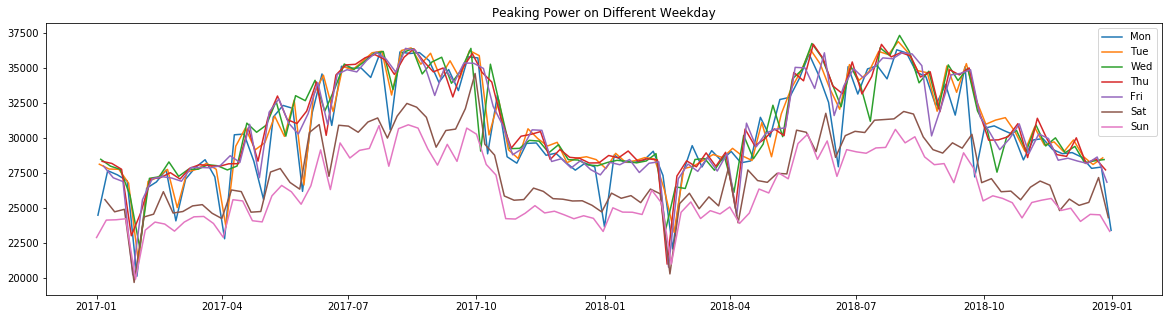

In [9]:
name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_week = [None] * 7
plt.figure(figsize = (20,5))
y_data1718 = y_data['2017':'2018']
temper1718 = temper['2017':'2018']
for day in range(7):
    y_week[day] = y_data1718[data['Weekday'] == day]  
    plt.plot(y_week[day], label=name[day])
plt.legend(loc='upper right')   
plt.title('Peaking Power on Different Weekday')

  * 將一週 7 天的電力尖峰負載分開繪圖，發現週六、日的電力尖峰負載明顯比週間日低

Mon   0.7964990774944223
Tue   0.8466449971008116
Wed   0.8778739414933602
Thu   0.8591664897754903
Fri   0.865538482859688
Sat   0.85321128325952
Sun   0.827301219958645


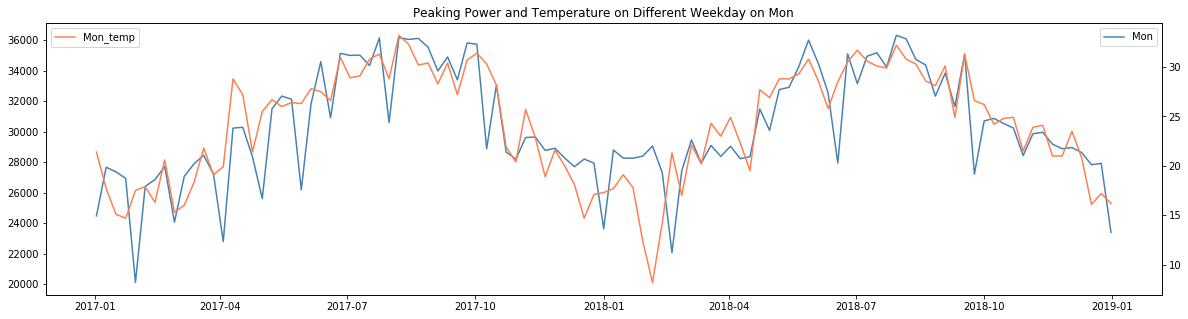

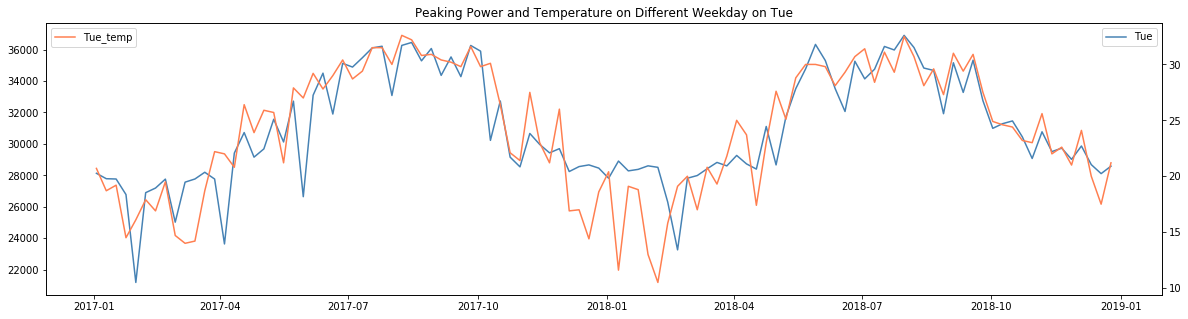

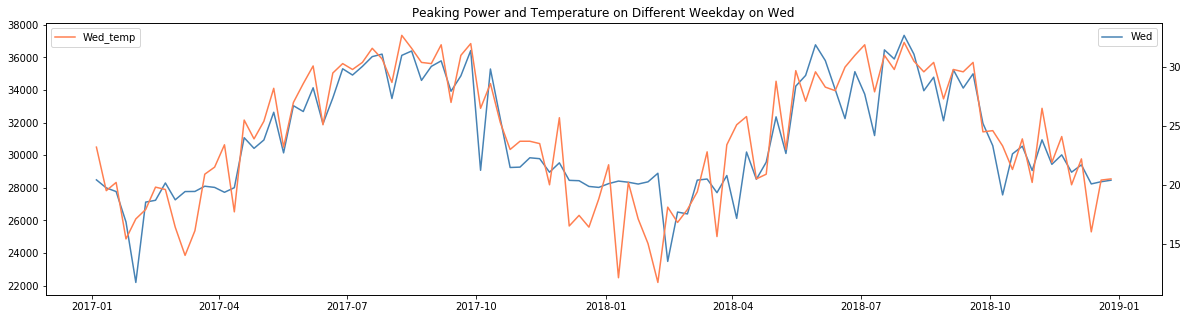

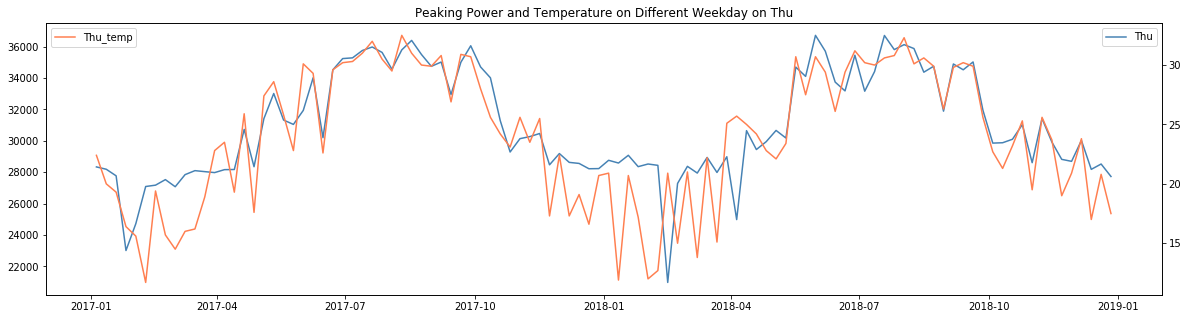

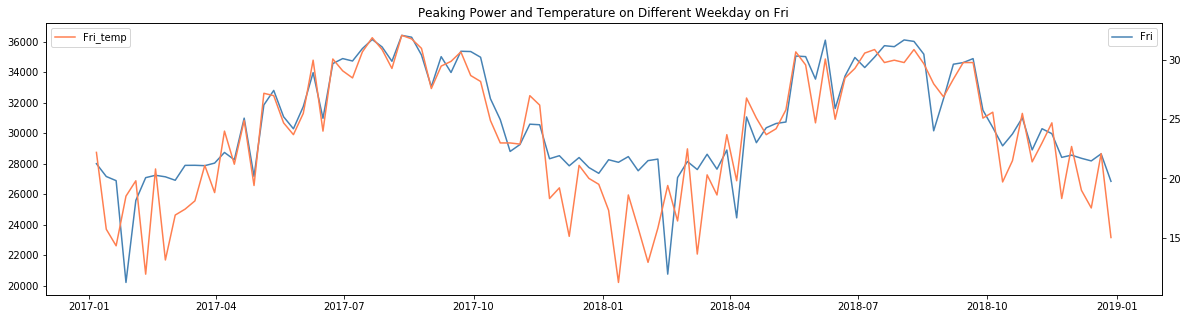

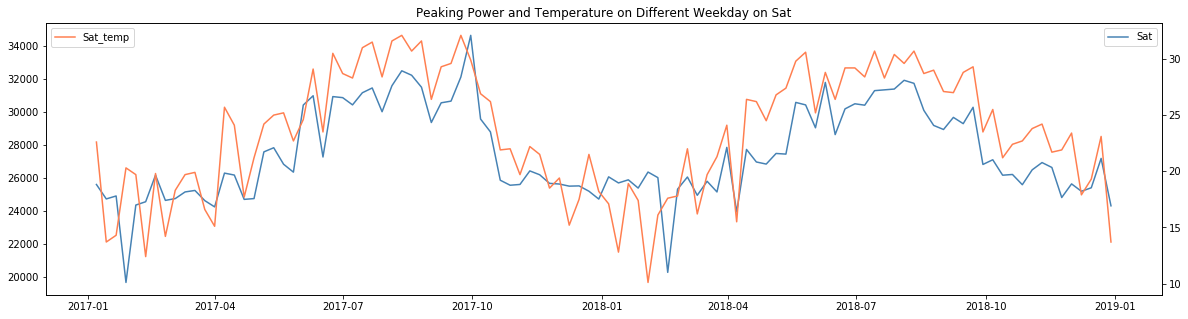

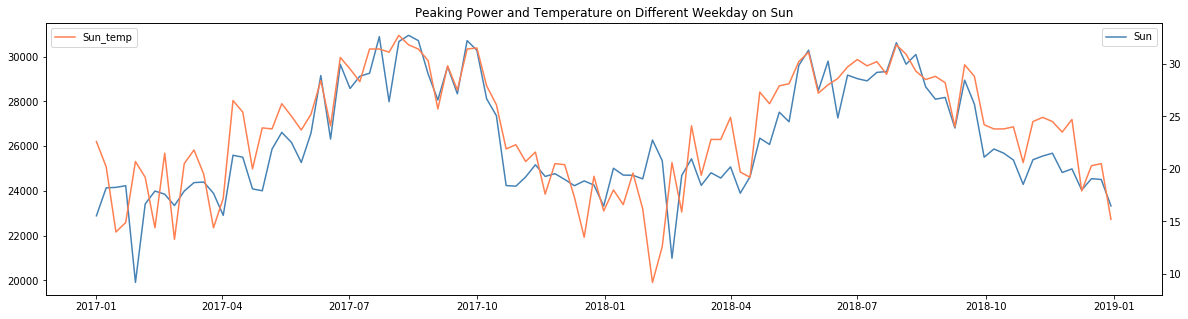

In [10]:
temp_week = [None] * 7

for day in range(7):
    y_week[day] = y_data1718[data['Weekday'] == day]  
    temp_week[day] = temper1718[data['Weekday'] == day]  
    fig = plt.figure(figsize = (20,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(y_week[day],color='steelblue',label=name[day])
    ax1.legend(loc='upper right')
    ax2 = ax1.twinx()
    ax2.plot(temp_week[day],color='coral',label=name[day]+'_temp')
    ax2.legend(loc='upper left')
    plt.title('Peaking Power and Temperature on Different Weekday on '+name[day])
    
    print(name[day]," ",y_week[day].corr(temp_week[day]))

  * 一週 7 天電力尖峰負載和溫度的相關係數和示意圖

# Model Selection

* 由上可知電力尖峰負載和溫度有高度正相關，又週末的數值會較週間低
* 初步想法：
    1. 使用 Linear Regression
    2. 一週中每一天分開做

## Linear Regression

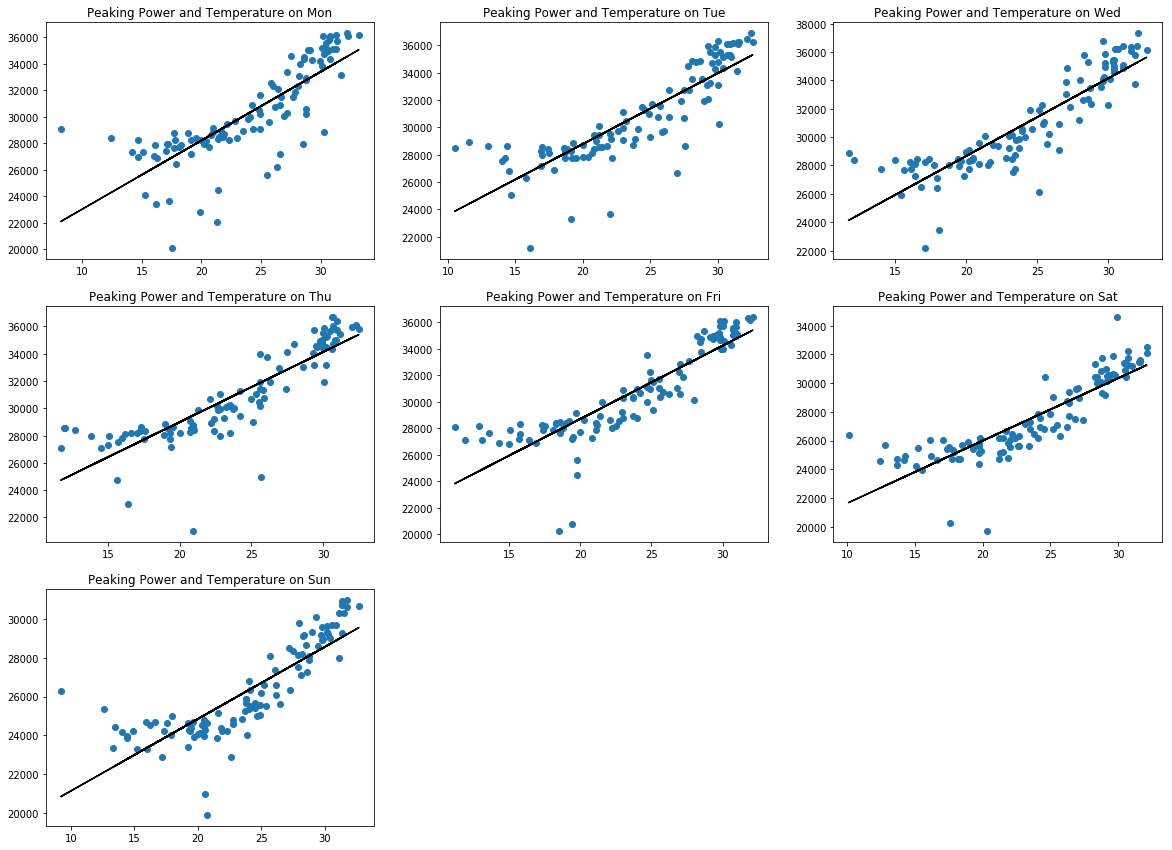

In [11]:
from sklearn.linear_model import LinearRegression

lm_trainX = [None] * 7
lm_trainY = [None] * 7
lm = [None] * 7
plt.figure(figsize = (20,20))
for day in range(7):
    lm_trainX[day] = np.reshape(temp_week[day].values,(len(temp_week[day].values), 1))
    lm_trainY[day] = np.reshape(y_week[day].values,(len(y_week[day].values), 1))
    lm[day] =  LinearRegression()
    lm[day].fit(lm_trainX[day], lm_trainY[day])
        
    plt.subplot(4, 3, day+1)
    plt.scatter(lm_trainX[day], lm_trainY[day])
    plt.plot( lm_trainX[day], lm[day].predict( lm_trainX[day]), color='black')
    
    plt.title('Peaking Power and Temperature on '+name[day])

* 從尖峰負載和溫度的散佈圖發現兩者的關係趨勢比起直線多了一點凹度，因此下面做了二次回歸

## Polynomial Features

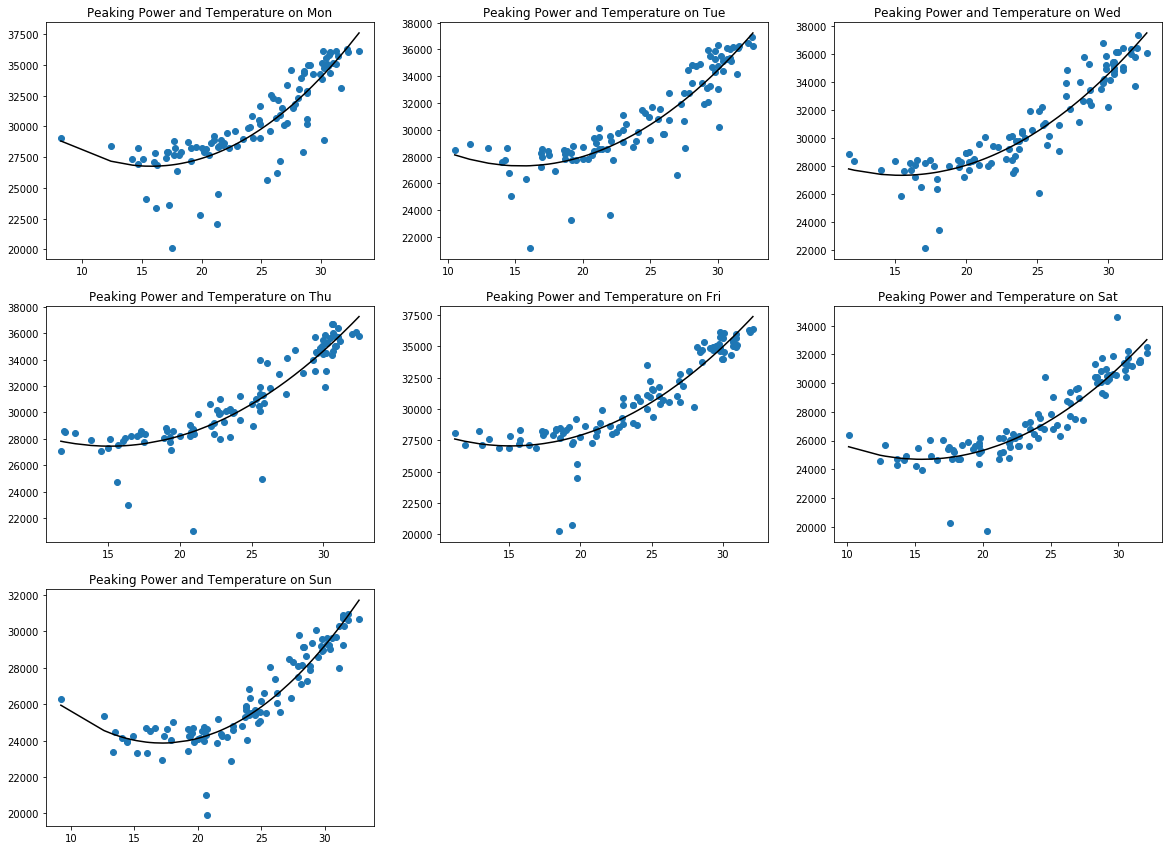

In [12]:
from sklearn.preprocessing import PolynomialFeatures

lm_trainX = [None] * 7
lm_trainX2 = [None] * 7
lm_trainY = [None] * 7
lm2 = [None] * 7
poly = PolynomialFeatures(degree=2)
plt.figure(figsize = (20,20))
for day in range(7):
    lm_trainX[day] = np.reshape(temp_week[day].values,(len(temp_week[day].values), 1))
    lm_trainY[day] = np.reshape(y_week[day].values,(len(y_week[day].values), 1))
    poly.fit(lm_trainX[day])
    lm_trainX2[day] = poly.transform(lm_trainX[day])
    lm2[day] =  LinearRegression()
    lm2[day].fit(lm_trainX2[day], lm_trainY[day])
    
    y_predict2 = lm2[day].predict(lm_trainX2[day])
    plt.subplot(4, 3, day+1)
    plt.scatter(lm_trainX[day], lm_trainY[day])
    plt.plot( np.sort(temp_week[day].values), y_predict2[np.argsort(temp_week[day].values)], color='black')
    
    plt.title('Peaking Power and Temperature on '+name[day])   

### workday
* 將星期一到星期五合併做二次回歸

Text(0.5, 1.0, 'Polynomial Regression of Peaking Power and Temperature on Workday')

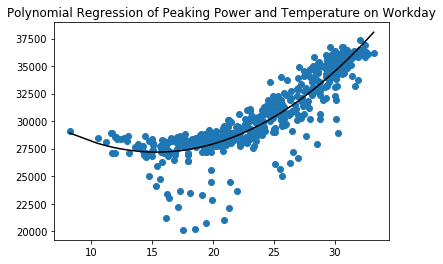

In [13]:
y_workday =  y_data1718[(data['Weekday'] >= 0) & (data['Weekday'] <= 4)]
temp_workday = temper1718[(data['Weekday'] >= 0) & (data['Weekday'] <= 4)]  

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)

lm_workday_trainX = np.reshape(temp_workday.values,(len(temp_workday.values), 1))
lm_workday_trainY = np.reshape(y_workday.values,(len(y_workday.values), 1))
poly.fit(lm_workday_trainX)
lm_workday_trainX2 = poly.transform(lm_workday_trainX)
lm_workday2 =  LinearRegression()
lm_workday2.fit(lm_workday_trainX2, lm_workday_trainY)
y_predict = lm_workday2.predict(lm_workday_trainX2)
plt.figure()
plt.scatter(lm_workday_trainX, lm_workday_trainY)
plt.plot( np.sort(temp_workday.values), y_predict[np.argsort(temp_workday.values)], color='black')
 
plt.title('Polynomial Regression of Peaking Power and Temperature on Workday') 

### weekend

* 將星期六日合併做二次回歸

Text(0.5, 1.0, 'Polynomial Regression of Peaking Power and Temperature on weekend')

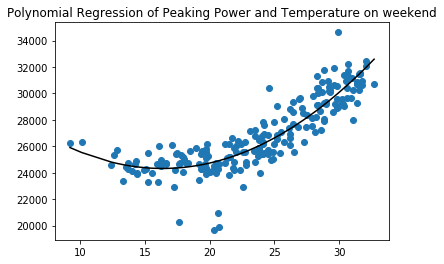

In [14]:
y_weekend =  y_data1718[data['Weekday'] >=5]
temp_weekend = temper1718[data['Weekday'] >=5]  

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)

lm_weekend_trainX = np.reshape(temp_weekend.values,(len(temp_weekend.values), 1))
lm_weekend_trainY = np.reshape(y_weekend.values,(len(y_weekend.values), 1))
poly.fit(lm_weekend_trainX)
lm_weekend_trainX2 = poly.transform(lm_weekend_trainX)
lm_weekend2 =  LinearRegression()
lm_weekend2.fit(lm_weekend_trainX2, lm_weekend_trainY)
y_predict = lm_weekend2.predict(lm_weekend_trainX2)
plt.figure()
plt.scatter(lm_weekend_trainX, lm_weekend_trainY)
plt.plot( np.sort(temp_weekend.values), y_predict[np.argsort(temp_weekend.values)], color='black')
 
plt.title('Polynomial Regression of Peaking Power and Temperature on weekend') 

## Evaluation
* 以 2019/01 的資料比較不同種 model 方法的RMSE
    1. Linear Regression ( 線性回歸 ) / 一週 7 個 model
    2. Polynomial Features ( 二次回歸 ) / 一週 7 個 model
    3. Polynomial Features ( 二次回歸 ) / workday
    4. Polynomial Features ( 二次回歸 ) / weekend

In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

y_data19 = y_data['2019']
temper19 = temper['2019']
y_week19 = [None] * 7
temp_week19 = [None] * 7

lm_testX = [None] * 7
lm_testX2 = [None] * 7
lm_testY = [None] * 7
y_pred_test = [None] * 7
err_poly = [None] * 7
for day in range(7):
    y_week19[day] = y_data19[data['Weekday'] == day]  
    temp_week19[day] = temper19[data['Weekday'] == day] 
    
    lm_testX[day] = np.reshape(temp_week19[day].values,(len(temp_week19[day].values), 1))
    lm_testY[day] = np.reshape(y_week19[day].values,(len(y_week19[day].values), 1))
    poly.fit(lm_testX[day])
    lm_testX2[day] = poly.transform(lm_testX[day])
    y_pred_test[day] = lm2[day].predict(lm_testX2[day])
    
    err_poly[day] = rmse(y_pred_test[day].T,y_week19[day].values.T)
    
err_poly

[907.6817405607503,
 1636.2817241415269,
 826.7109495426985,
 701.9532468190266,
 258.7805048282682,
 917.4543888323018,
 640.1448335920861]

In [16]:
err_lr = [None] * 7 
for day in range(7):
    lm_testX[day] = np.reshape(temp_week19[day].values,(len(temp_week19[day].values), 1))
    lm_testY[day] = np.reshape(y_week19[day].values,(len(y_week19[day].values), 1))
    y_pred_test[day] = lm[day].predict(lm_testX[day])
    
    err_lr[day] = rmse(y_pred_test[day].T,y_week19[day].values.T)
err_lr

[1038.8537630159344,
 1705.30700144133,
 1312.303277554793,
 1234.9123577769487,
 928.245098543187,
 788.2570355082623,
 699.8483814487829]

In [17]:
y_workday19 = y_data19[(data['Weekday'] >= 0) & (data['Weekday'] <= 4)]  
temp_workday19 = temper19[(data['Weekday'] >= 0) & (data['Weekday'] <= 4)] 
    
lm_workday_testX = np.reshape(temp_workday19.values,(len(temp_workday19.values), 1))
lm_workday_testY = np.reshape(y_workday19.values,(len(y_workday19.values), 1))
poly.fit(lm_workday_testX)
lm_workday_testX2 = poly.transform(lm_workday_testX)
y_pred_test = lm_workday2.predict(lm_workday_testX2)
    
err_workday = rmse(y_pred_test.T,y_workday19.values.T)
err_workday

968.9399451278441

In [18]:
y_weekend19 = y_data19[data['Weekday'] >= 5]  
temp_weekend19 = temper19[data['Weekday'] >= 5] 
    
lm_weekend_testX = np.reshape(temp_weekend19.values,(len(temp_weekend19.values), 1))
lm_weekend_testY = np.reshape(y_weekend19.values,(len(y_weekend19.values), 1))
poly.fit(lm_weekend_testX)
lm_weekend_testX2 = poly.transform(lm_weekend_testX)
y_pred_test = lm_weekend2.predict(lm_weekend_testX2)
    
err_weekend = rmse(y_pred_test.T,y_weekend19.values.T)
err_weekend

1003.6556614588958

* 由上面三筆 RMSE 發現
    1. 二次回歸整體而言效果較線性回歸好
    2. 將週一到週五用一個 model 預測，誤差較分成 5 個 model 的平均誤差小
    3. 將週末用一個 model 預測，誤差較分成 2 個 model 的平均誤差大
* 因此決定採用 - 二次回歸 / 一週 3 個 model - workday, Say, Sun

# Prediction

* 根據天氣預報中最高最低氣溫的平均預測該日電力尖峰負載

In [60]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')
with open('201904_temp.csv', 'r') as f:   
     weather1904 = pd.read_csv(f, parse_dates=['date'], date_parser=dateparse, index_col=0)
max_temper1904 = pd.Series(weather1904['T Max'],index=weather1904.index)
min_temper1904 = pd.Series(weather1904['T Min'],index=weather1904.index)
temper1904 = (max_temper1904+min_temper1904)/2
weekdayr1904 = weather1904.index.weekday
weather1904.head(7)    

,T Max,T Min
date,,
2019-04-02,22,18
2019-04-03,23,19
2019-04-04,25,19
2019-04-05,25,19
2019-04-06,26,20
2019-04-07,27,20
2019-04-08,24,20


* 因為 2019/4/4 - 2019/4/7 是連假，根據 2017、2018 的清明連假數據顯示連假期間電力尖峰負載也會接近假日的趨勢，因此將他們的 weekday 改為星期六六六日

In [61]:
weekdayr1904.values[2] = 5
weekdayr1904.values[3] = 6
weekdayr1904.values[4] = 6
weekdayr1904

Int64Index([1, 2, 5, 6, 6, 6, 0], dtype='int64', name='date')

In [62]:
x_1904 = [None] * len(weather1904)
temper1904_2 = [None] * len(weather1904)
y_pred_1904 = np.zeros(len(weather1904))
for day in range(len(weather1904)):
    x_1904[day] = np.reshape(temper1904[day], (1, -1))
    poly.fit(x_1904[day])
    temper1904_2[day] = poly.transform(x_1904[day])
    y_pred_1904[day] = lm2[weekdayr1904[day]].predict(temper1904_2[day])
    
y_pred_1904

array([28005.31083901, 28437.84330699, 25972.86976093, 24617.35539347,
       24963.90034419, 25161.62325452, 28145.73542498])

In [63]:
err_pred = [None] * 7 
yy = [28700,28600,25700,24600,24300,24500,28500]
for day in range(len(weather1904)):
    err_pred[day] = rmse(y_pred_1904[day].T,yy[day])
err_pred

[694.6891609926824,
 162.1566930056033,
 272.8697609346127,
 17.35539346502628,
 663.9003441905807,
 661.6232545184284,
 354.26457502109406]

* 和未來一週電力供需預測做 RMSE 結果

In [64]:
np.mean(err_pred)

403.8370260182897

## Output result

In [58]:
result = pd.DataFrame()
result['peak_load(MW)'] = (y_pred_1904).astype(np.int)
result.index = weather1904.index

result.head(7)   

,peak_load(MW)
date,
2019-04-02,28005
2019-04-03,28437
2019-04-04,25972
2019-04-05,24617
2019-04-06,24963
2019-04-07,25161
2019-04-08,28145


In [59]:
with open('submission.csv', 'w', newline='\n') as f:
    result.to_csv(f,date_format='%Y%m%d')